# Run full Granual Predictions

What needs to happen:
- ~~function to temporally and spatially interpolate MERRA2~~
- ~~function to read MERRA2 with interpolation~~
  - PS = surface_pressure
  - T10M = 10-meter_air_temperature (Andy will investigate)
  - TO3 = total_column_ozone
  - TQV = total_precipitable_water_vapor
- ~~function to read VNP02MOD~~
  - in group "observation_data"
    - M14 (for center wavelengths at 8500 nm)
    - M15 (for center wavelengths at 10800 nm)
    - M16 (for center wavelengths at 12000 nm)
- ~~function to read VNP03MOD~~
  - in group "geolocation_data"
    - sensor_azimuth
    - sensor_zenith
    - solar_azimuth
    - solar_zenith
- combine above for model inputs
- check if there are any transformations that need to be made on the inputs before sening them though the model
- load the saved model (see tensorflow.keras.models.load_model as in evaluate.ipynb)
- call the saved model's "predict" method on the combined inputs

## Setup

In [1]:
from pathlib import Path

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from hot_dust import preprocess, DATADIR

## Load the VIIRS Granules

In [2]:
# granules
vnp02 = "VNP02MOD.A2020168.1448.002.2021127084950.nc"
vnp03 = "VNP03MOD.A2020168.1448.002.2021125194020.nc"

In [3]:
# open WITHOUT mask_and_scale to access observations as integers (ignore scale and offset)
open_vnp02_int = xr.open_dataset(
    DATADIR / "granules" / vnp02,
    group="observation_data",
    mask_and_scale=False,
)
# open WITH mask_and_scale to access LUT values as floats (with NaNs)
open_vnp02 = xr.open_dataset(
    DATADIR / "granules" / vnp02,
    group="observation_data",
)

# create new xr.Dataset to contain viirs_bts
vnp02_variables = xr.Dataset()
for item in ["M14", "M15", "M16"]:
    vnp02_variables[item + "_bt"] = open_vnp02[item + "_brightness_temperature_lut"][open_vnp02_int[item]]
    long_name = vnp02_variables[f"{item}_bt"].attrs["long_name"]
    vnp02_variables[item + "_bt"].attrs["long_name"] = long_name.replace(" lookup table", "")

In [4]:
# open (just open, no tricks here)
open_vnp03 = xr.open_dataset(
    DATADIR / "granules" / vnp03,
    group="geolocation_data",
)

# select the relavant variables
vnp03_variables = open_vnp03[["sensor_zenith", "solar_zenith"]]

# compute relative azimuth
array = np.abs(open_vnp03["solar_azimuth"] - open_vnp03["sensor_azimuth"])
vnp03_variables["relative_azimuth"] = array.where(array <= 180, 360 - array)

In [5]:
# merge the model imputs
vnp02_vnp03 = xr.merge([vnp02_variables, vnp03_variables])
vnp02_vnp03

<xarray.Dataset>
Dimensions:           (number_of_lines: 3232, number_of_pixels: 3200)
Dimensions without coordinates: number_of_lines, number_of_pixels
Data variables:
    M14_bt            (number_of_lines, number_of_pixels) float32 ...
    M15_bt            (number_of_lines, number_of_pixels) float32 ...
    M16_bt            (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith     (number_of_lines, number_of_pixels) float32 ...
    solar_zenith      (number_of_lines, number_of_pixels) float32 ...
    relative_azimuth  (number_of_lines, number_of_pixels) float32 32.34 ... 1...

## Extract MERRA-2 Input Variables

The "raw" cell below has code to read the MERRA2 files directly from AWS, so it will not run locally. The output has been commited to DVC, however, so it does not need to be re-run unless the preprocessing code changes.

In [6]:
# Merge all the merra files
merra_variables = xr.open_dataset(DATADIR / 'merra' / vnp03) 

# Drop the coordinates 
merra_variables = merra_variables.drop(['time', 'lon', 'lat'])

# Divide the MERRA2 pressure by 100 to get it in the right units
merra_variables['PS'] = merra_variables['PS']/100 
merra_variables

<xarray.Dataset>
Dimensions:  (number_of_lines: 3232, number_of_pixels: 3200)
Dimensions without coordinates: number_of_lines, number_of_pixels
Data variables:
    PS       (number_of_lines, number_of_pixels) float64 965.8 ... 1.024e+03
    TS       (number_of_lines, number_of_pixels) float64 ...
    TO3      (number_of_lines, number_of_pixels) float64 ...
    TQV      (number_of_lines, number_of_pixels) float64 ...

In [7]:
# xr stack number of lines and pixels vnp03 and vnp02 make it 1D using the stack function
variables_merged = xr.merge([vnp02_vnp03, merra_variables]) # Merge 1st, then stack

## 2D Plot of Input Variables

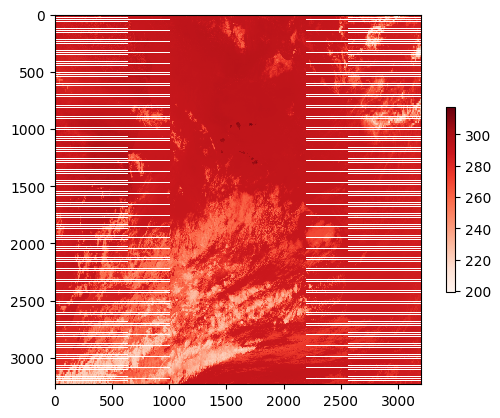

In [8]:
# M14 Map (red)
plt.imshow(variables_merged["M14_bt"], cmap="Reds", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()  

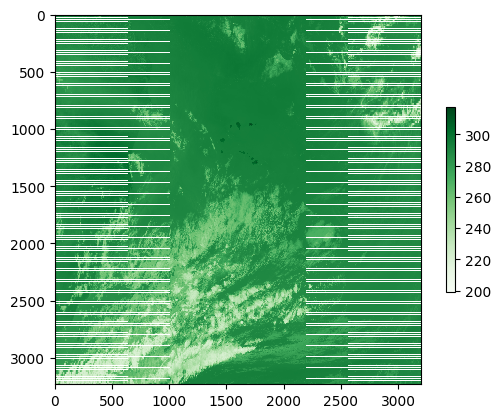

In [9]:
# M15 Map (green)
plt.imshow(variables_merged["M15_bt"], cmap="Greens", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

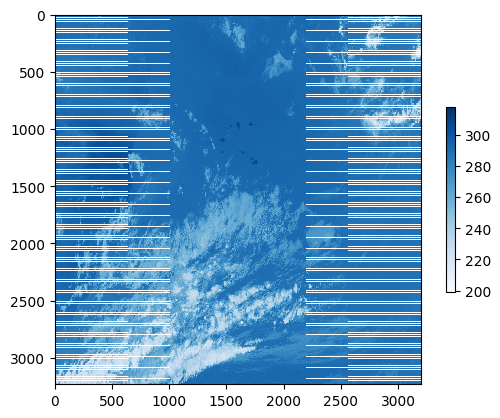

In [10]:
# M16 Map (blue)
plt.imshow(variables_merged["M16_bt"], cmap="Blues", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

## Transform to Model Input

In [11]:
# the features list must give the same data as the features list in hot_dust.preprocess.prepare_training_data
features = [
    "solar_zenith",
    "sensor_zenith",
    "relative_azimuth",
    "PS",
    "TQV",
    "TO3",
#    "ws",  # FIXME: wind speed is missing from merra2!
    "TS",
    "M14_bt",
    "M15_bt",
    "M16_bt",
]

x = variables_merged[features].to_array("feature").stack({"sample": ('number_of_lines', 'number_of_pixels')})
x = x.dropna(dim="sample")
x

<xarray.DataArray (feature: 10, sample: 9010816)>
array([[ 27.17000008,  27.15999985,  27.14999962, ...,  11.06999969,
         11.05999947,  11.05000019],
       [ 36.43000031,  36.36999893,  36.30999756, ...,  36.27000046,
         36.32999802,  36.39999771],
       [ 41.26000214,  41.27000427,  41.29000092, ..., 164.27999878,
        164.27000427, 164.26000977],
       ...,
       [291.14477539, 291.07702637, 290.87341309, ..., 289.04733276,
        289.04733276, 288.65557861],
       [293.45785522, 293.45785522, 293.27700806, ..., 291.74905396,
        291.74905396, 291.27017212],
       [291.35470581, 291.26672363, 291.17593384, ..., 290.23934937,
        290.19497681, 289.84494019]])
Coordinates:
  * feature           (feature) object 'solar_zenith' ... 'M16_bt'
  * sample            (sample) object MultiIndex
  * number_of_lines   (sample) int64 0 0 0 0 0 0 ... 3231 3231 3231 3231 3231
  * number_of_pixels  (sample) int64 1008 1009 1010 1011 ... 2188 2189 2190 2191

## Generate Predictions

## 2D Plot of Predicted Dust Optical Thickness

## WIP / Scratch

In [12]:
xr.open_dataset("data/rt_nn_irdust_training_data.nc")

<xarray.Dataset>
Dimensions:                 (npoints: 250000, nbands_viirs: 3)
Coordinates:
  * nbands_viirs            (nbands_viirs) float32 8.5e+03 1.08e+04 1.2e+04
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle      (npoints) float32 ...
    viewing_zenith_angle    (npoints) float32 ...
    relative_azimuth_angle  (npoints) float32 ...
    viirs_bts               (nbands_viirs, npoints) float32 ...
    dust_optical_thickness  (npoints) float32 ...
    dust_central_height     (npoints) float32 ...
    spress                  (npoints) float32 ...
    h2o                     (npoints) float32 ...
    o3                      (npoints) float32 ...
    ws                      (npoints) float32 ...
    ts                      (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 20230803
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [13]:
xr.open_dataset("data/granules/GMAO_MERRA2.20200616T140000.MET.nc")

<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    PS        (lat, lon) float32 ...
    QV10M     (lat, lon) float32 ...
    SLP       (lat, lon) float32 ...
    T10M      (lat, lon) float32 ...
    TO3       (lat, lon) float32 ...
    TQV       (lat, lon) float32 ...
    U10M      (lat, lon) float32 ...
    V10M      (lat, lon) float32 ...
    FRSNO     (lat, lon) float32 ...
    FRSEAICE  (lat, lon) float32 ...
Attributes: (12/39)
    date_created:                      2022-03-02T06:13:36Z
    title:                             GMAO MERRA2 2D Hourly,  Instantaneous,...
    product_name:                      GMAO_MERRA2.20200616T140000.MET.nc
    history:                           gmao_met_merge -asm MERRA2_400.inst1_2...
    time_coverage_start:               2020-06-16T14:00:00Z
    time_coverage_end:                 2020-06-16T14:00:00Z
    ...                                ...
    identifier_product_doi:            10.5067/3Z173KIE2TPD;10.5067/RKPHT8KC1...
    processing_level:                  L4
    cdm_data_type:                     grid
    spatialResolution:                 0.5x0.625 degrees
    source:                            MERRA2_400.inst1_2d_asm_Nx.20200616.nc...
    comment:                           This file contains a subset of variabl...